In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import random
import cv2                  
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Model
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


In [2]:
def apply_otsu_binary_threshold(image):
    """
    Otsu's 이진화를 적용하여 이미지를 흑백으로 변환
    :param image: 입력 이미지
    :return: 이진화된 이미지
    """
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Otsu's 이진화 적용
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return binary_image

In [3]:
def binary_threshold(image, threshold=180):
    """
    이진화를 적용하여 흑백 이미지 생성
    :param image: 입력 이미지
    :param threshold: 이진화 임계값
    :return: 이진화된 이미지
    """
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이진화 적용
    _, binary_image = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)

    return binary_image

In [4]:
def functional_model(HEIGHT, WIDTH, outdim):
    # Define the input layer
    inputs = Input(shape=(HEIGHT, WIDTH, 1)) # check01

    # First convolutional and pooling layers
    x = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional and pooling layers
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Third convolutional and pooling layers
    x = Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Fourth convolutional and pooling layers
    x = Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Flattening the output for the dense layers
    x = Flatten()(x)

    # Dense layer with 512 units
    x = Dense(512)(x)
    x = Activation('relu')(x)

    # Output layer with softmax activation
    outputs = Dense(outdim, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# modelling starts using a CNN.
class network(tf.keras.Model):
    def __init__(self, HEIGHT, WIDTH, outdim):
        super(network, self).__init__()
        
        self.conv1 = Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(HEIGHT, WIDTH, 3))
        self.maxpool1 = MaxPooling2D(pool_size=(2, 2))

        self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu')
        self.maxpool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        self.conv3 = Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu')
        self.maxpool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        self.conv4 = Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu')
        self.maxpool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        self.flatten = Flatten()
        self.dense1 = Dense(512)
        self.activation1 = Activation('relu')
        self.dense2 = Dense(outdim, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.maxpool4(x)

        x = self.flatten(x)
        x = self.dense1(x)
        x = self.activation1(x)
        output = self.dense2(x)

        return output

In [6]:
# project(i, initial_path, HEIGHT, WIDTH, outdim) i는 checkpoint, initial_path는 대오더라벨까지 저장하는 최상위 폴더, HEIGHT는 높이, WIDTH는 가로, outdim 은 타겟변수의 차원값.

class project(network):
    def __init__(self, i, initial_path, HEIGHT, WIDTH, outdim, epochs, samplesize):
        super().__init__(HEIGHT, WIDTH, outdim)
        self.HEIGHT, self.WIDTH, self.outdim = HEIGHT, WIDTH, outdim
        # self.model = network(self.HEIGHT, self.WIDTH, self.outdim)
        self.model = functional_model(self.HEIGHT, self.WIDTH, self.outdim)
        self.i = i
        self.epochs = epochs
        self.initial_path = initial_path
        self.le=LabelEncoder()
        self.samplesize = samplesize

    '''
    data_loader : i 는 checkpoint를 의미. initial_path는 data가 들어있는 최초의 폴더를 의미.
    사용법
    X, Z = data_loader()
    '''
    def data_loader(self):
        X=[]
        Z=[]
        QR_list = os.listdir(self.initial_path) # The list of bigorderlabels
        for QR in QR_list:
            checklist_path = os.path.join(self.initial_path, QR)
            image_list = os.listdir(checklist_path)[0:self.samplesize] #check03
            for image in image_list: # image in Data/bigorderlabel/checkpoint/testing folder, example : Data/5951C001AA/(1)/fail folder
                path = os.path.join(checklist_path, image)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.WIDTH, self.HEIGHT)) # check02
                binary_image_otsu = apply_otsu_binary_threshold(img)
                binary_image_otsu = np.array(binary_image_otsu)
                binary_image_otsu = np.expand_dims(binary_image_otsu, axis=-1)
                X.append(binary_image_otsu)
                Z.append(str(QR))
        return X, Z
    
    '''
    data_encoder : 이미지 데이터를 모델에 넣을 수 있는 형태로 변환하는 작업.
    '''
    def data_encoder(self):
        self.X, self.Z = self.data_loader()
        Y=self.le.fit_transform(self.Z)
        Y=to_categorical(Y,2)
        X=np.array(self.X)
        X=X/255
        self.x_train, self.x_test, self.y_train, self.y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

    '''
    training: Epoch = 20, batch_size = 128, red_lr로 callback method 사용함.
    '''
    def training(self):
        batch_size=128
        optimizer=RMSprop(learning_rate=0.001)
        self.model.compile(optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
        self.History = self.model.fit(self.x_train, self.y_train, batch_size=batch_size,
                              epochs = self.epochs, validation_data = (self.x_test, self.y_test),
                              verbose = 1, steps_per_epoch=self.x_train.shape[0] // batch_size)
    
    # loss plot graph. history의 훈련 과정에서 loss의 추세를 보여줌
    def loss_plot(self):
        plt.plot(self.History.history['loss'])
        plt.plot(self.History.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.yscale('log')
        plt.show()
    # accuracy plot graph. history의 훈련 과정에서 accuracy의 추세를 보여줌
    def accuracy_plot(self):
        plt.plot(self.History.history['accuracy'])
        plt.plot(self.History.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.yscale('log')
        plt.show()
    # 우리 딥러닝 모델의 L2 에러를 보여줌.
    def error(self):
        self.pred = self.model.predict(self.x_test)
        error = np.absolute(self.pred - self.y_test)
        error_L_2 = np.linalg.norm(error, 2) / np.sqrt(len(self.pred))
        return error_L_2

In [7]:
# 객체 생성
initial_path = '../QRcode'
sample = cv2.imread(os.path.join(os.path.join(initial_path, os.listdir(initial_path)[0]), os.listdir(os.path.join(initial_path, os.listdir(initial_path)[0]))[0]))
samplesize = len(os.listdir(os.path.join(initial_path, os.listdir(initial_path)[0])))
HEIGHT, WIDTH, _ = np.array(sample).shape
outdim = 2
PROJECT = project(2, initial_path, HEIGHT, WIDTH, outdim, 20, samplesize)
# 데이터를 불러오는 작업
PROJECT.data_encoder()

2024-01-11 13:14:10.187464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 13:14:11.256838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22299 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-01-11 13:14:11.257395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22300 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-01-11 13:14:11.257826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0

In [8]:
PROJECT.training()

2024-01-11 13:14:14.938304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2024-01-11 13:14:16.043793: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2024-01-11 13:14:16.618442: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-01-11 13:14:16.632343: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 13:14:18.035786: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 7s 602ms/step - loss: 15.7679 - accuracy: 0.5391 - val_loss: 0.4811 - val_accuracy: 0.6691
Epoch 2/20
4/4 [==============================] - 3s 406ms/step - loss: 0.9593 - accuracy: 0.8568 - val_loss: 0.1079 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 322ms/step - loss: 0.0393 - accuracy: 1.0000 - val_loss: 8.7479e-04 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 323ms/step - loss: 6.3969e-04 - accuracy: 1.0000 - val_loss: 1.3138e-04 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 325ms/step - loss: 1.0895e-04 - accuracy: 1.0000 - val_loss: 4.6472e-05 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 2s 398ms/step - loss: 4.5400e-05 - accuracy: 1.0000 - val_loss: 2.4751e-05 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 399ms/step - loss: 2.0720e-05 - accuracy: 1.0000 - val_loss: 1.3208e-05 - val_accuracy: 1

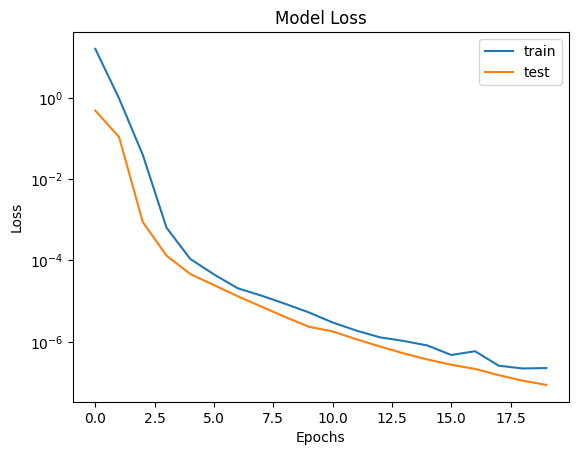

In [9]:
PROJECT.loss_plot()

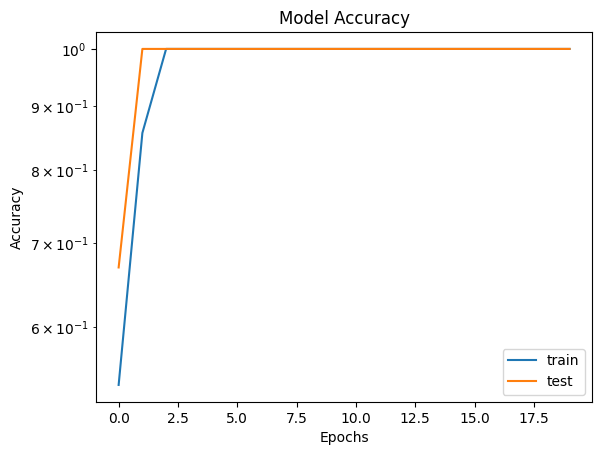

In [10]:
PROJECT.accuracy_plot()

In [11]:
PROJECT.error()

2.3745380397602802e-07

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 마지막 feature maps에 대한 모델의 미분을 계산하기 위해서
    # 마지막 feature maps과 모델을 최종 예측값을 동시에 출력하는 모델을 새롭게 정의한다.
    # 이것은 케라스 문법이기 때문에 익숙치 않을 수 있다. 
    #    - Model 함수의 첫 번째 인자는 입력 객체, 두 번째 인자는 출력 객체이다.
    #    - 마지막 feature maps과 최종 예측값 두 개를 출력한다.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 이건 텐서플로우 문법이다.
    # 모델에 이미지가 입력되고, 마지막 feature maps과 최종 예측값을 구하는 일련의 연산 과정을
    # Computational graph라는 형태로 저장해놓는다. 이렇게 해야 미분값을 계산할 수 있다.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # 우리의 모델은 num_classes개의 예측값을 출력한다. 각 예측값은 데이터가 해당 클래스 확률값이다.
        # 미분 (더 정확히는 그레디언트)는 한 개의 예측값에 대해서 계산할 수 있기 때문에
        # 가장 확률값이 큰 예측값에 대응하는 클래스 (혹은 함수의 인자로 전달한 클래스)만을 고려할 것이다. -> class_channel
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 이 친구가 바로 미분 계산이다. 
    # 모델의 어떤 한 클래스에 대한 예측값(class_channel) 을 마지막 feature maps(last_conv_layer_output)으로 미분한다.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # 마지막 feature maps은 여러 개의 채널을 갖고 있다. (현재 [1, 높이, 너비, 채널] 상태, 1은 데이터 개수)
    # 각 채널마다 등장한 미분값들을 평균 내려주자. (채널의 중요도를 결정)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 우리는 마지막 feature maps에서 중요한 위치를 알고 싶다. 
    # 하지만 채널 개수가 많기 때문에 어떤 위치가 중요한지 결정해줘야 한다.
    # 채널의 중요도를 가중치로 가중합을 해주자 ([높이, 너비, 1]가 됨)
    last_conv_layer_output = last_conv_layer_output[0]
    # @는 행렬곱 연산이다. 축을 잘 맞춰줌으로써 행렬곱이 곧 가중합 연산이 되도록 한 것이다.
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] 
    heatmap = tf.squeeze(heatmap)  # 축 쥐어짜서 (squeeze) 없애주기 ([높이, 너비, 1] -> [높이, 너비]가 됨)

    # 0과 1사이 값으로 만들어주기
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [13]:
def subplot(n):
    heatmap = make_gradcam_heatmap(PROJECT.x_test[n:n+1], PROJECT.model, 'max_pooling2d_7')
    heatmap = np.array(heatmap)
    heatmap = cv2.resize(heatmap, (WIDTH, HEIGHT))
    plt.imshow(PROJECT.x_test[n])
    plt.imshow(heatmap, alpha=0.5)
    plt.show()
    # plt.savefig('subplot{}.png'.format(n))

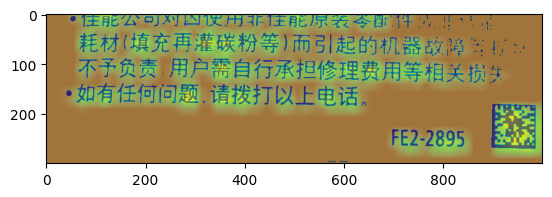

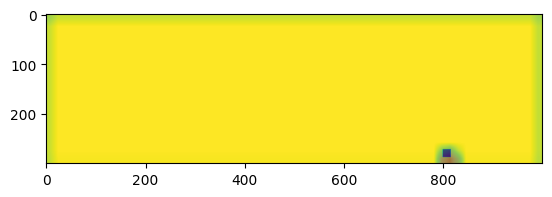

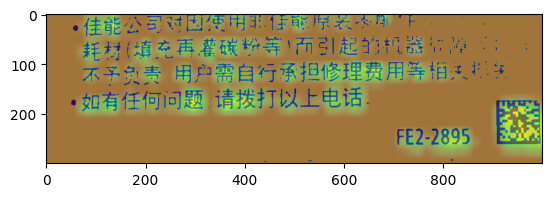

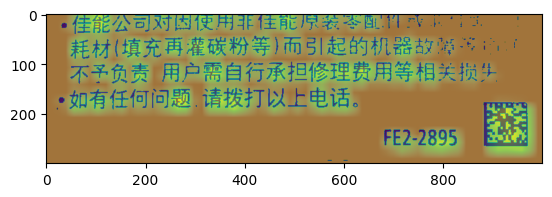

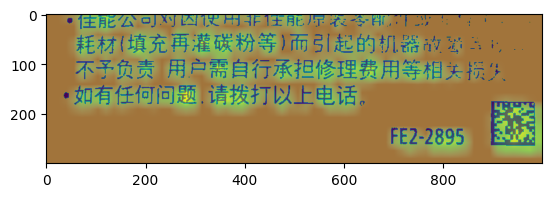

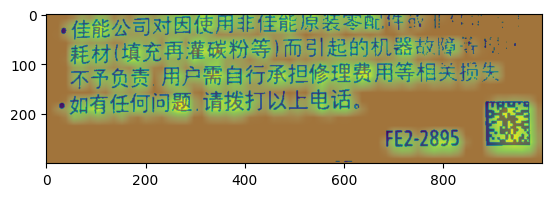

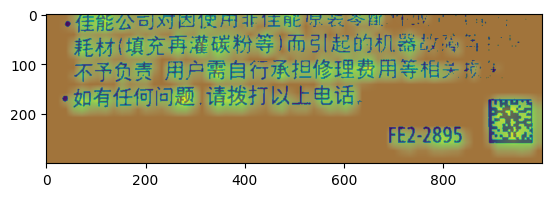

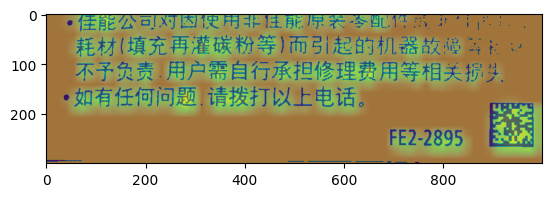

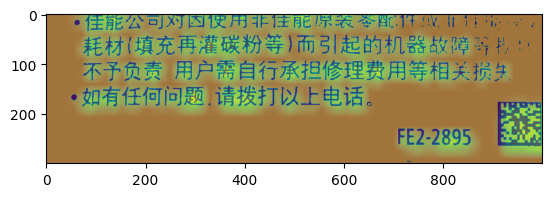

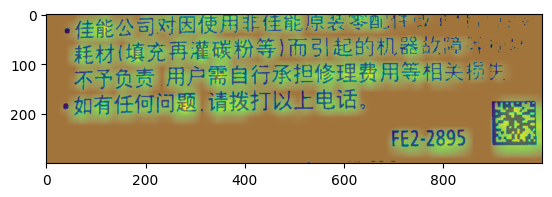

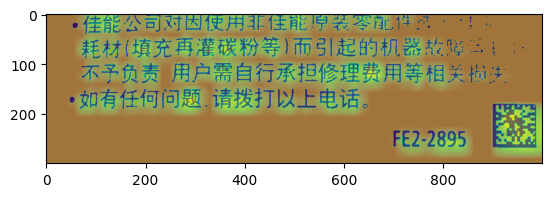

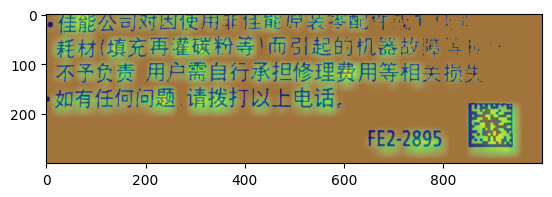

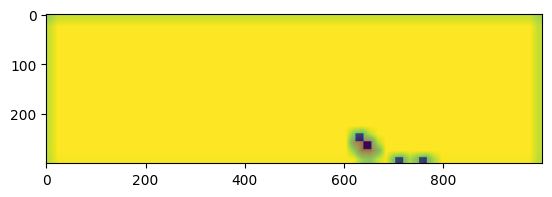

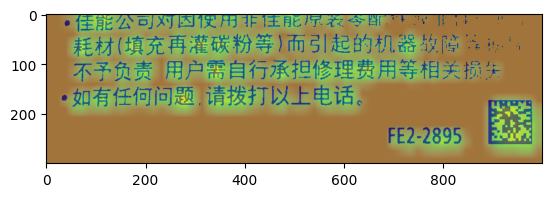

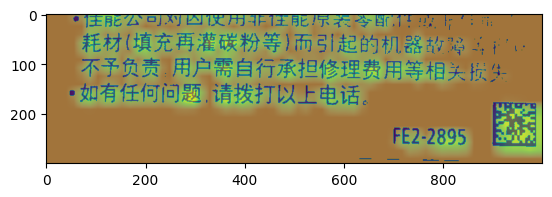

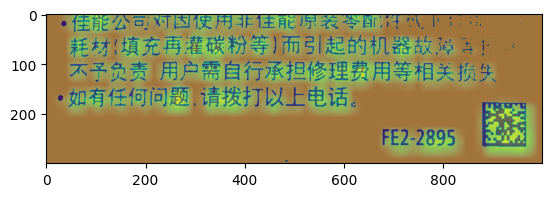

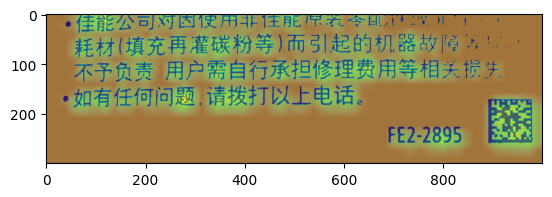

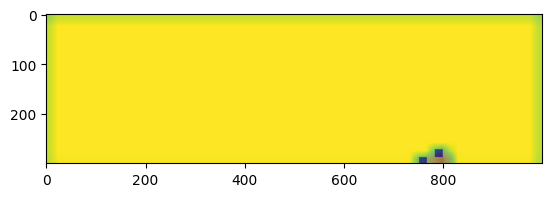

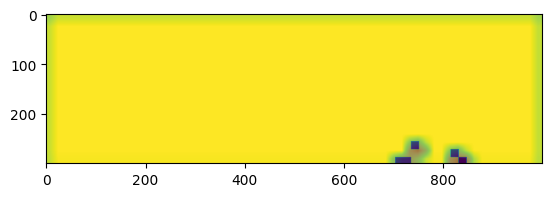

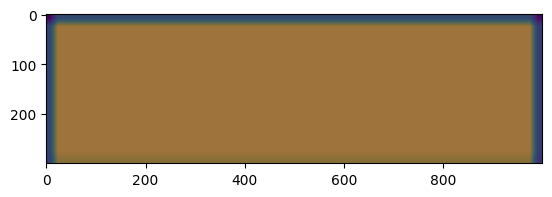

In [14]:
for i in range(20):
    subplot(i)

In [15]:
def subplot(n):

    heatmap = make_gradcam_heatmap(PROJECT.x_test[n:n+1], PROJECT.model, 'max_pooling2d_7')

    # 가로로 두 개의 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # 첫 번째 서브플롯에 그래프 그리기
    ax1.imshow(heatmap)
    ax1.set_title('heatmap')

    # 두 번째 서브플롯에 그래프 그리기
    ax2.imshow(PROJECT.x_test[n])
    ax2.set_title('Image')

    # 레이아웃 조정 및 그래프 표시
    plt.tight_layout()
    plt.show()

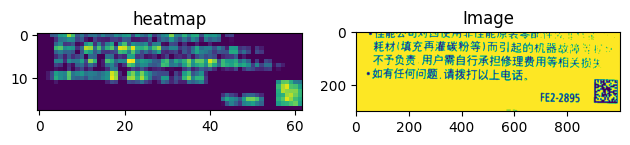

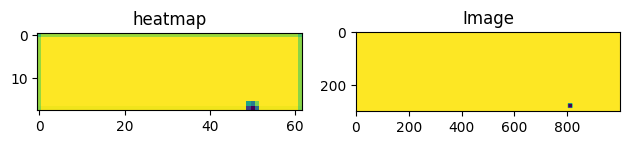

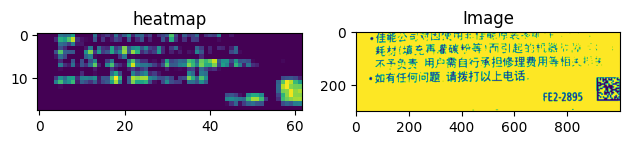

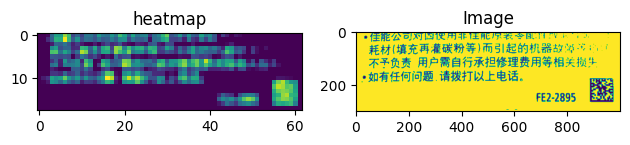

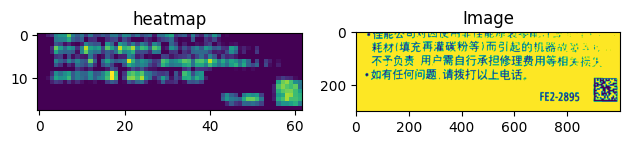

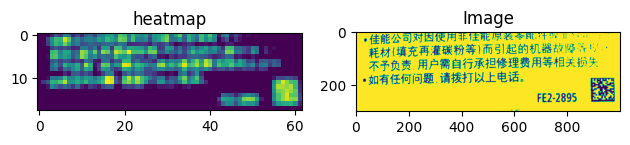

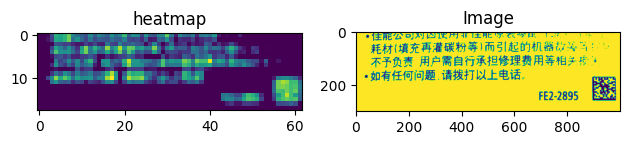

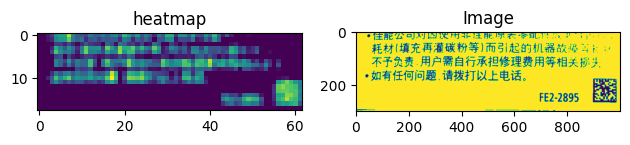

In [16]:
for i in range(8):
    subplot(i)

In [17]:
PROJECT.model.save('../model/QR_model.h5')
